# Testing for ideas

In [32]:
# samples = os.listdir(DATA_DIR)

# testsample = samples[0]
# image_dir = os.path.join(DATA_DIR, testsample, 'Raw')
# mask_dir = os.path.join(DATA_DIR, testsample, 'Mask')

# nuc_img = mpl.pyplot.imread(os.path.join(image_dir, 'nuclei.tiff'))
# nuc_img = rescale_intensity(nuc_img, (100, 400)) # need to manually set the intensity range
# nuc_img = nuc_img[600:nuc_img.shape[0], 0:600]

# nuc_cvseg = segmentation.chan_vese(nuc_img, mu=0.25, lambda1=1, lambda2=1, tol=1e-3,
#                max_num_iter=200, dt=0.5, init_level_set="checkerboard",
#                extended_output=True)

# fig, axes = mpl.pyplot.subplots(1, 2, figsize=(8, 5))
# ax = axes.flatten()

# ax[0].imshow(nuc_img, cmap="gray")
# ax[0].set_axis_off()
# ax[0].set_title("Original Image", fontsize=12)

# ax[1].imshow(nuc_cvseg[0])
# ax[1].set_axis_off()
# title = f'Chan-Vese segmentation'
# ax[1].set_title(title, fontsize=12)

In [31]:
# nuc_mask = mpl.pyplot.imread(os.path.join(mask_dir, 'mask.tiff'))
# nuc_mask = nuc_mask[600:nuc_mask.shape[0], 0:600]

# fig, axes = mpl.pyplot.subplots(1, 2, figsize=(8, 5))
# ax = axes.flatten()

# ax[0].imshow(nuc_img, cmap="gray")
# ax[0].set_axis_off()
# ax[0].set_title("Original Image", fontsize=12)

# ax[1].imshow(nuc_mask, cmap='gray')
# ax[1].set_axis_off()
# ax[1].set_title('mask', fontsize=12)

## Evolve curve around an object

In [1]:
import numpy as np
from scipy.ndimage import gaussian_filter, laplace
from skimage.io import imshow, imsave, imread
from skimage.draw import disk, circle_perimeter
import matplotlib as mpl
import os
import cv2 as cv

%matplotlib inline

In [2]:
ROOT = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(ROOT, 'Data')

In [10]:
# Initialize a guesss of the contour
def initialize(img):
    '''
    Distance transforming image into a family of level sets psi = +/-d
    The psi = 0 level always yields the moving front of a shape, aka the curve.
    '''
    img = np.clip(img, 0, 255)
    img_invert = 255 - img # this step will change boundaries to 0
    img = img.astype('uint8')
    img_invert = img_invert.astype('uint8')
    # conver to single-channgle gray-scale image
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY) 
    img_invert = cv.cvtColor(img_invert, cv.COLOR_BGR2GRAY)
    # distance transform the image with a 3 x 3 kernel. 
    dist_img = cv.distanceTransform(img, cv.DIST_L2, 3) 
    img_invert[dist_img==dist_img.min()] = 255 # (omitted because we only need distance to the boundary) need to restore the boundaries
    dist_img_invert = cv.distanceTransform(img_invert, cv.DIST_L2, 3)
    dist_img = -1 * dist_img # the distances inside the boundaries are negative
    psi = np.zeros_like(img)
    psi = np.where(dist_img < 0, dist_img, dist_img_invert)
    # psi = dist_img + dist_img_invert # now the boundaries are fixed and zero
    return psi

def draw_curve(psi, axis, colors='red', levels=[0]):
    '''
    Draw curve U on an image. By default, it is drawn in the red channel
    '''
    # curve at zero-crossing
    # draw levels with equal spacings
    # find the curve that cross zero level
    from matplotlib.pyplot import contour
    X = np.arange(0, psi.shape[1])
    Y = np.arange(0, psi.shape[0])
    X, Y = np.meshgrid(X, Y)
    Z = psi[X, Y]
    return contour(X, Y, Z, levels=levels, colors=colors)

def central_difference(psi):
    '''
    Compute central differences along x-axis, y-axis, and between x,y-axes
    '''
    if psi.shape[0] < 1 or psi.shape[1] < 1:
        print('Image has invalid shape: expected sizes of dimensions to be greater than 1.')
    # expanding psi to prevent shrinking in size after taking differences
    psi = np.hstack((psi[:,0][:, np.newaxis], psi))
    psi = np.hstack((psi, psi[:,psi.shape[1]-1][:, np.newaxis]))
    psi = np.vstack((psi[0,:][np.newaxis, :], psi))
    psi = np.vstack((psi, psi[psi.shape[0]-1,:][np.newaxis, :]))
    m, n = psi.shape
    # print(m,n)
    dx = 0.5 * (psi[2:m, 1:n-1]-psi[0:m-2, 1:n-1])
    dy = 0.5 * (psi[1:m-1, 2:n]-psi[1:m-1, 0:n-2])
    dxx = (psi[2:m, 1:n-1] - psi[1:m-1, 1:n-1]) - (psi[1:m-1, 1:n-1] - psi[0:m-2, 1:n-1])
    dyy = (psi[1:m-1, 2:n] - psi[1:m-1, 1:n-1]) - (psi[1:m-1, 1:n-1] - psi[1:m-1, 0:n-2])
    dxy = 0.25 * ((psi[2:m, 2:n] - psi[0:m-2, 2:n]) - (psi[2:m, 0:n-2] - psi[0:m-2, 0:n-2]))
    return dx, dy, dxx, dyy, dxy

def curve_evolution(img, dt=0.1, max_iter=1000, v=1):
    '''
    Evolve the curve based on the magitude the image gradient, curvature and gradient of image
    '''
    psi = initialize(img) # initialize psi
    # TODO: blur psi with 0.5 sigma
    # imshow(psi)
    dx, dy, dxx, dyy, dxy = central_difference(psi)
    # imshow(dxy)
    dx, dy = np.gradient(psi) # central differences of psi in curvature motion flow
    grad_mag = np.sqrt(dx**2 + dy**2)
    K = (dxx*dy**2 - 2*dy*dx*dxy + dyy*dx**2) / ((dx**2 + dy**2)**1.5 + np.finfo('float').eps) # curvature K
    # TODO: change the sign of kappa, inward motion
    # TODO: Adjust force according to the gradient of the image
    # TODO: May also try adjusting the sign of the force based on the region in which the point lie 
    for i in range(max_iter):
        dpsi = K * grad_mag * dt # let speed equals to curvature K
        psi[:] = psi[:] + dpsi
    return psi
    

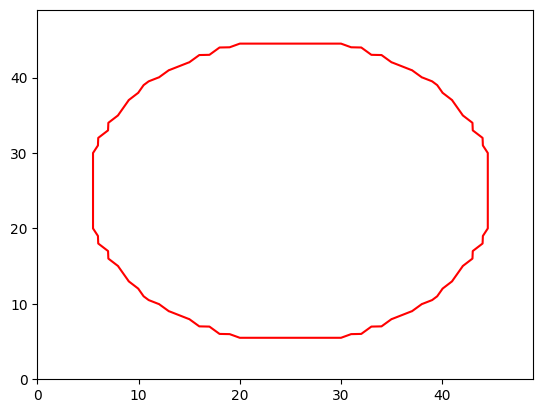

In [11]:
import matplotlib.pyplot as plt
img = imread(os.path.join(DATA_DIR, 'example', 'test.png'))

fig, ax = plt.subplots()
draw_curve(curve_evolution(img, max_iter=5), axis=ax)
# fig, axs = plt.subplots(nrows=10, ncols=5, figsize=(50,100))
# axs = axs.ravel()
# for max_iter, ax in zip(range(50), axs.flat()):
#     draw_curve(curve_evolution(img, max_iter=max_iter), axis=ax)